In [1]:
from traitlets.config.manager import BaseJSONConfigManager
from pathlib import Path
path = Path.home() / ".jupyter" / "nbconfig"
cm = BaseJSONConfigManager(config_dir=str(path))
cm.update(
    "rise",
    {
        "theme": "serif",
        "transition": "zoom",
        "start_slideshow_at": "selected",
     }
)

{'theme': 'serif', 'transition': 'zoom', 'start_slideshow_at': 'selected'}

# AI Use cases of recommendation systems empowered by good MLOps practices
## Ing. MSc Jose Oñate
## Ing. MEng. Casimiro Rocha

In [ ]:
import  
import random
from ast import literal_eval

import numpy as np
import pandas as pd
import requests

import umap
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from scipy.spatial.distance import cdist
from sentence_transformers import SentenceTransformer
from skimage import io

## Case Based Reasoning

# 1. Retrieve: Given a target problem, retrieve from memory cases relevant to solving it. A case consists of a problem, its solution, and, typically, annotations about how the solution was derived.


https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/download?datasetVersionNumber=7

# Data Processing: Movies Data Base


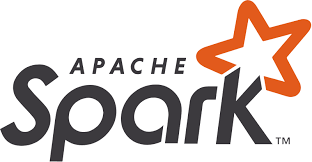
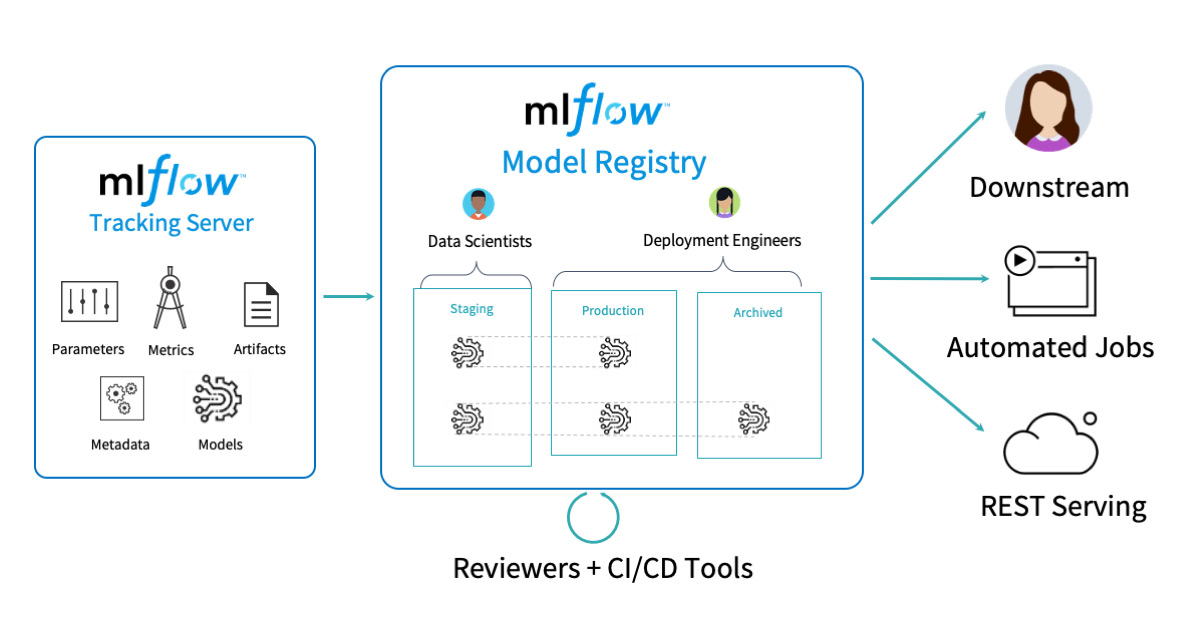


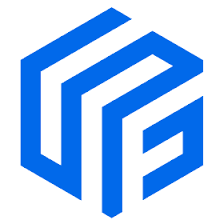
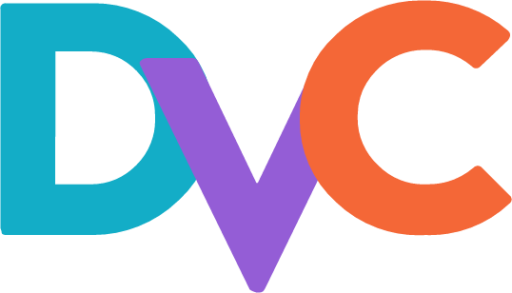

In [ ]:
movies_data = pd.read_csv("movies/files/movies_metadata.csv", low_memory=False)
movies_data = movies_data.loc[movies_data.release_date >= "1990"]
movies_data = movies_data.loc[np.array([x.isnumeric() for x in movies_data.id])]
movies_data.id = movies_data.id.astype(int)
movies_data.popularity = movies_data.popularity.astype(float)
movies_data.fillna({"poster_path": "", "runtime": 0, "original_language": ""}, inplace=True)
movies_data = movies_data.loc[:, [
    "id", "original_title", "release_date", "original_language",
    "runtime", "vote_average", "vote_count",
    "popularity", "poster_path", "production_companies", "genres",
    "overview",
]]
movies_data = movies_data.loc[
    (movies_data.genres != "[]") & \
    (movies_data.original_language != "") & \
    (movies_data.poster_path != "") & \
    (movies_data.runtime > 0) & \
    (movies_data.original_language == "en") & \
    (movies_data.production_companies != "[]")
]
movies_data.shape

In [ ]:
# add keywords
keywords = pd.read_csv("movies/files/keywords.csv")
keywords = keywords.loc[keywords.keywords != "[]"]
movies_data = pd.merge(movies_data, keywords, on="id", how='inner')
movies_data.drop_duplicates("id", inplace=True, ignore_index=True)
print(movies_data.shape)
movies_data.iloc[0].to_dict()

In [ ]:
# add credits
credits = pd.read_csv("movies/files/credits.csv")
credits = credits.loc[(credits.crew != "[]") & (credits.cast != "[]")]
movies_data = pd.merge(movies_data, credits, on="id", how='inner')
movies_data.drop_duplicates("id", inplace=True, ignore_index=True)
movies_data.shape

In [ ]:
# dict fields
features = ["cast", "crew", "keywords", "genres", "production_companies"]
for feature in features:
    movies_data[feature] = movies_data[feature].apply(literal_eval)

In [ ]:
# Director
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return ""

movies_data['director'] = movies_data['crew'].apply(get_director)

In [ ]:
# Year
def get_year(x):
    return int(x.split("-")[0])

movies_data['year'] = movies_data['release_date'].apply(get_year)

In [ ]:
# list fields
def get_list(x):
    if isinstance(x, list):
        names = [i["name"] for i in x]
        return names

    # Return empty list in case of missing/malformed data
    return []

features = ["cast", "keywords", "genres", "production_companies"]
for feature in features:
    movies_data[feature] = movies_data[feature].apply(get_list)

In [ ]:
movies_data.drop(columns="crew", inplace=True)

In [ ]:
movies_data.to_parquet("movies/movies_data.parquet")

In [ ]:
# load movies data
movies_data = pd.read_parquet("movies/movies_data.parquet")
movies_data.shape

In [ ]:
for key, value in movies_data.iloc[0].to_dict().items():
    print(f"{key}: {value}")

#### Web Scraping from TMDb 

In [ ]:
poster_path = "/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg"
url = f"https://image.tmdb.org/t/p/w185{poster_path}"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:50.0) Gecko/20100101 Firefox/50.0'}
response = requests.get(url, headers=headers)
response.status_code

## Data Characterization: Movie Vector Store
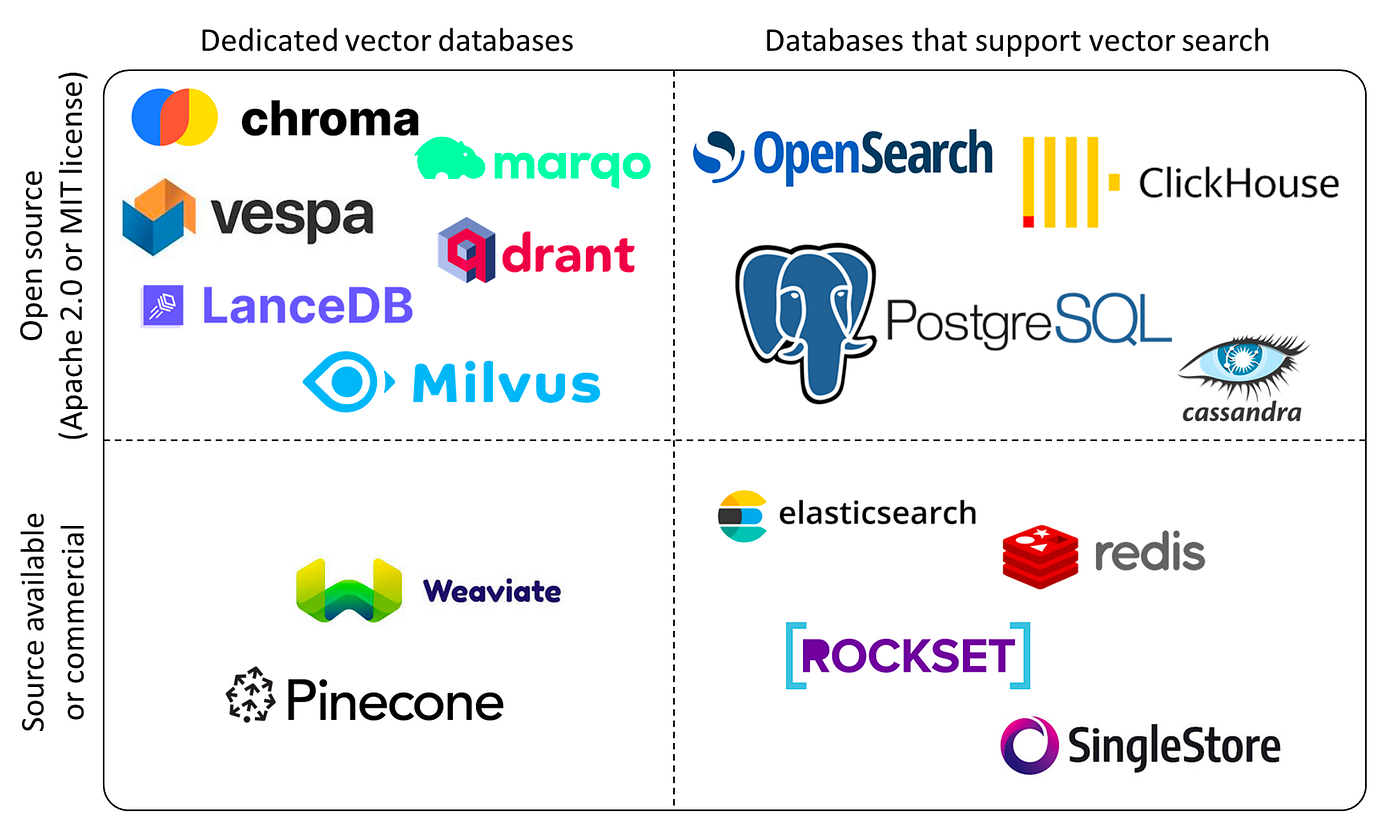


In [ ]:
content_base = []
for row in movies_data.to_dict("records"):
    genres = ", ".join(row["genres"])
    keys = ", ".join(row["keywords"])
    actors = ", ".join(row["cast"][:3])
    content_base.append((
        f"""{row["original_title"]} ({row["year"]}): {genres}. {row["overview"]} """
        f"""Produced by {"".join(row["production_companies"][:1])}. """
        f"""Directed by {row["director"]}. Main actors: {actors}."""
    ))
print(content_base[0])

In [ ]:
# Semantic Embedding
embedding_model = SentenceTransformer("all-mpnet-base-v2")  # all-MiniLM-L6-v2 all-mpnet-base-v2
embeddings = embedding_model.encode(content_base)
print(embeddings.shape)
with open("movies/movies_embeddings.pickle", "wb") as file:
    pickle.dump(embeddings, file)
with open("movies/movies_embeddings.pickle", "rb") as file:
    embeddings = pickle.load(file)
print(embeddings.shape)

### Visualization
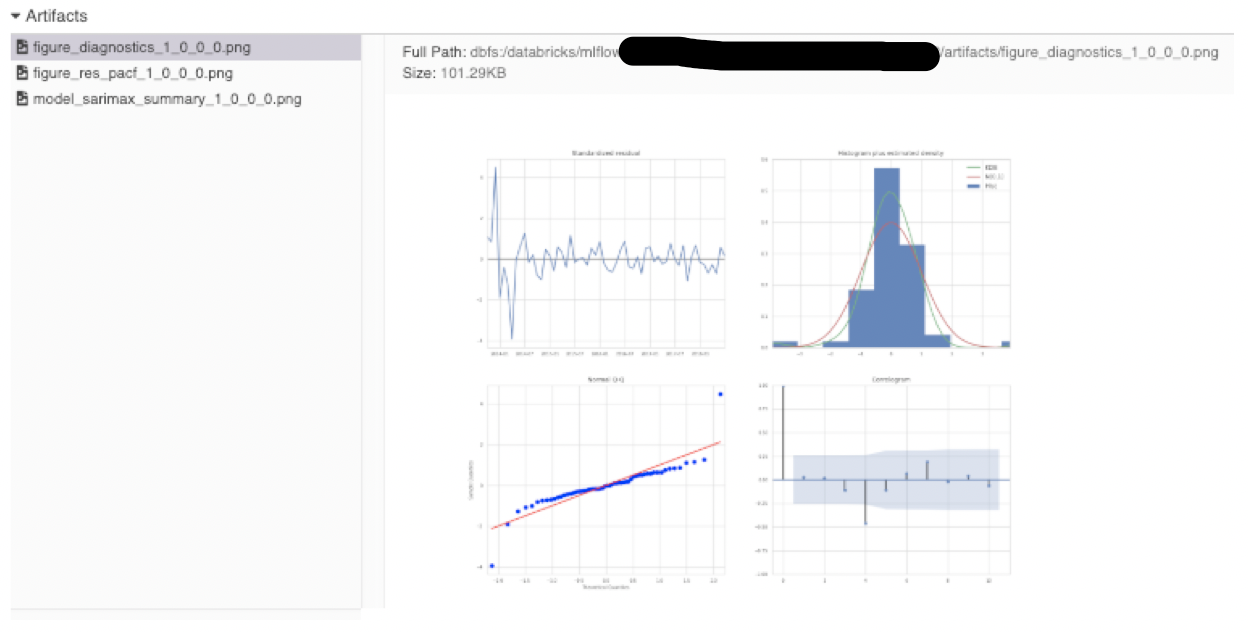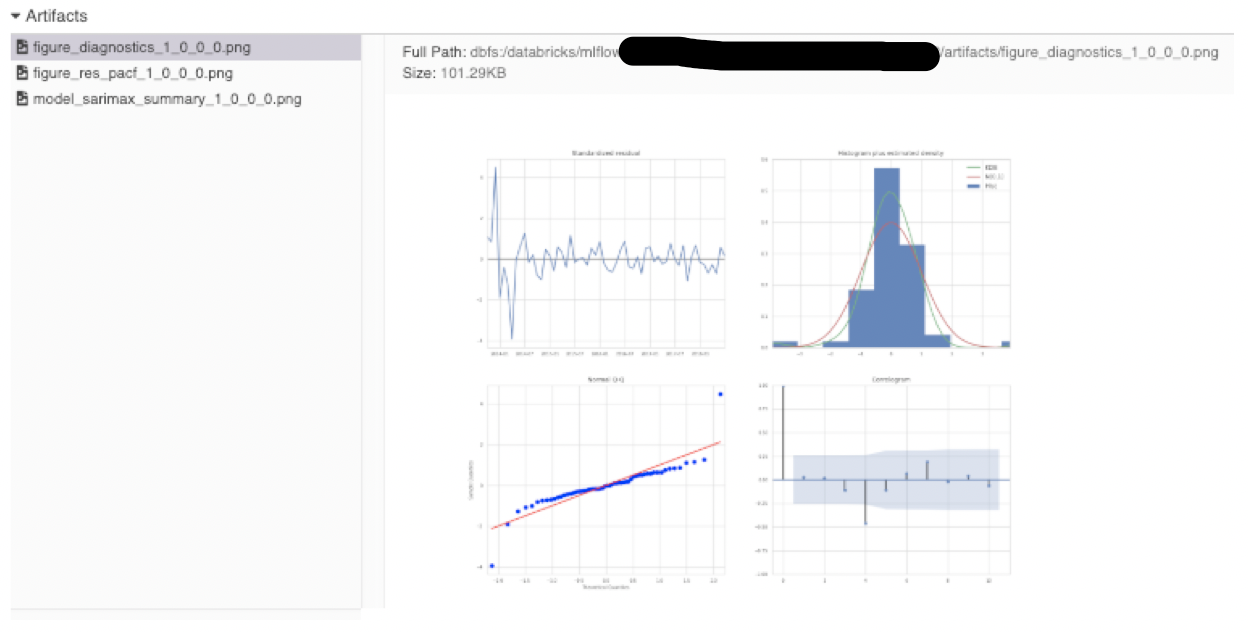

In [ ]:
reducer = umap.UMAP(
    random_state=42,
    n_components=2,
    n_neighbors=20,
    min_dist=0.1,
    metric="euclidean",
)
embeddings2d = reducer.fit_transform(embeddings)
embeddings2d.shape

def reduce_list(x):
    if isinstance(x, list):
        return x[:3]

    # Return empty list in case of missing/malformed data
    return []

features = ["keywords", "genres"]
for feature in features:
    movies_data[feature] = movies_data[feature].apply(reduce_list)

In [ ]:
ugenres = sorted(np.unique([x[0] for x in movies_data.genres.values]))
figure = go.Figure()
figure.add_trace(go.Scattergl(
    x=embeddings2d[:, 0],
    y=embeddings2d[:, 1],
    mode="markers",
    # marker_color=[ugenres.index(x[0]) for x in movies_data.genres.values],
    marker_line_width=1,
    opacity=0.5,
    customdata=movies_data.loc[:, ["original_title", "genres", "keywords", "year"]].values,
    hovertemplate="<br>".join([
        "title: %{customdata[0]}",
        "genres: %{customdata[1]}", 
        "keywords: %{customdata[2]}",
        "year: %{customdata[3]}",
    ]),
))
figure.update_layout(
    width=800,
    height=700,
    xaxis_visible=False,
    yaxis_visible=False,
)

## User Preferences Modeling

In [ ]:
movie_titles = movies_data.original_title.to_list()

def get_user_model(user_titles):
    user_model = {"titles": user_titles, "nodes": [], "radio": 0}
    for title in user_titles:
        idx = movie_titles.index(title)
        user_model["nodes"].append(list(embeddings2d[idx]))
    # Radio
    user_nodes = np.array(user_model["nodes"])
    node_dist = cdist(user_nodes, user_nodes)
    user_model["radio"] = np.min(node_dist[node_dist > 0]) / 2
    return user_model
user_titles = [
    "The Shawshank Redemption",
    "Forrest Gump",
    "Fight Club",
    "Inception",
    "The Matrix",
    "Se7en",
    "Saving Private Ryan",
    "WALL·E",
    "Good Will Hunting",
    "Heat",
]
user_model = get_user_model(user_titles)
print(user_model)

In [ ]:
def visualize_user_model(model_a, model_b=None):
    # visualization
    figure = go.Figure()
    # preferences spheres
    for i, node in enumerate(model_a["nodes"]):
        x = node[0]
        y = node[1]
        r = model_a["radio"]
        figure.add_shape(
            type="circle",
            fillcolor="yellow",
            opacity=0.5,
            x0=x-r, y0=y-r, x1=x+r, y1=y+r,
            line_color="black",
        )
        print(f"{i}. {model_a['titles'][i]}")
    figure.add_trace(go.Scattergl(
        x=embeddings2d[:, 0],
        y=embeddings2d[:, 1],
        mode="markers",
        marker_line_width=0,
        customdata=movies_data.loc[:, ["original_title", "genres", "keywords", "year"]].values,
        hovertemplate="<br>".join([
            "title: %{customdata[0]}",
            "genres: %{customdata[1]}", 
            "keywords: %{customdata[2]}",
            "year: %{customdata[3]}",
        ]),
        fillcolor="blue",
        opacity=0.5,
        name="movies-universe",
    ))
    figure.add_trace(go.Scattergl(
        x=np.array(model_a["nodes"])[:, 0],
        y=np.array(model_a["nodes"])[:, 1],
        mode="markers",
        fillcolor="red",
        opacity=1,
        name="user-model",
        marker_line_width=1,
    ))
    if model_b:
        figure.add_trace(go.Scattergl(
            x=np.array(model_b["nodes"])[:, 0],
            y=np.array(model_b["nodes"])[:, 1],
            mode="markers",
            fillcolor="green",
            opacity=1,
            name="case-base",
            marker_line_width=1,
        ))
    figure.update_layout(
        width=800,
        height=700,
        xaxis_visible=False,
        yaxis_visible=False,
    )
    figure.show()

In [ ]:
visualize_user_model(user_model)

# 0. Case Base:

In [ ]:
n_cases = 1_000
n_movies = movies_data.shape[0]
movies_per_case = 10

In [ ]:
case_base = []
itc = list(np.arange(n_movies).astype(int))
features = ["vote_average", "vote_count"]
for i in range(n_cases):
    ititles = []
    idxs = np.array(random.sample(itc, movies_per_case))
    iloc = embeddings2d[idxs]
    node_dist = cdist(iloc, iloc)
    rmin = np.min(node_dist[node_dist > 0]) / 2
    ifeature = random.choice(features)
    for ix in iloc:
        mdist = cdist(embeddings2d, ix.reshape(1, -1))
        imovies = movies_data.loc[mdist < rmin].sort_values(
            by=ifeature, ascending=False, ignore_index=True
        ).iloc[0].to_dict()
        if imovies["original_title"] in ititles:
            print("duplicated titles")
            break
        ititles.append(imovies["original_title"])
    if len(ititles) < movies_per_case:
        break
    icase = get_user_model(ititles)
    case_base.append(icase)
print(len(case_base))
visualize_user_model(random.choice(case_base))

In [ ]:
def search_by_content(key, k=10):
    return [x for x in movie_titles if key.lower() in x.lower()][:k]

print(search_by_content("Conj"))

In [ ]:
# Mixer
user_titles = [
    "The Silence of the Lambs",
    "Pride & Prejudice",
    "The Godfather: Part III",
    "Little Women",
    "The Sixth Sense",
    "Iron Man",
    "The Avengers",
    "Shrek 2",
    "Saving Private Ryan",
    "The Conjuring",
]
user_model = get_user_model(user_titles)
print(user_model)

# 2. Reuse: Map the solution from the previous case to the target problem. This may involve adapting the solution as needed to fit the new situation.

### Similarity Algorithm
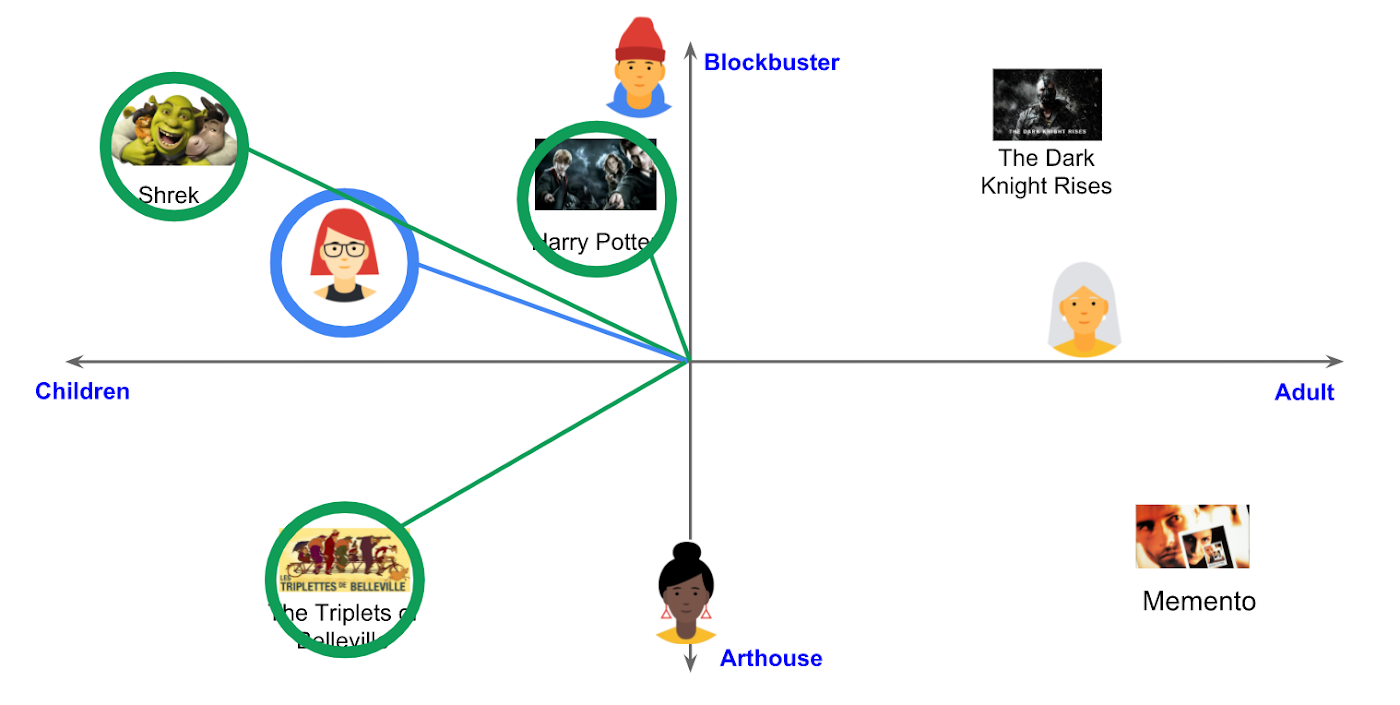
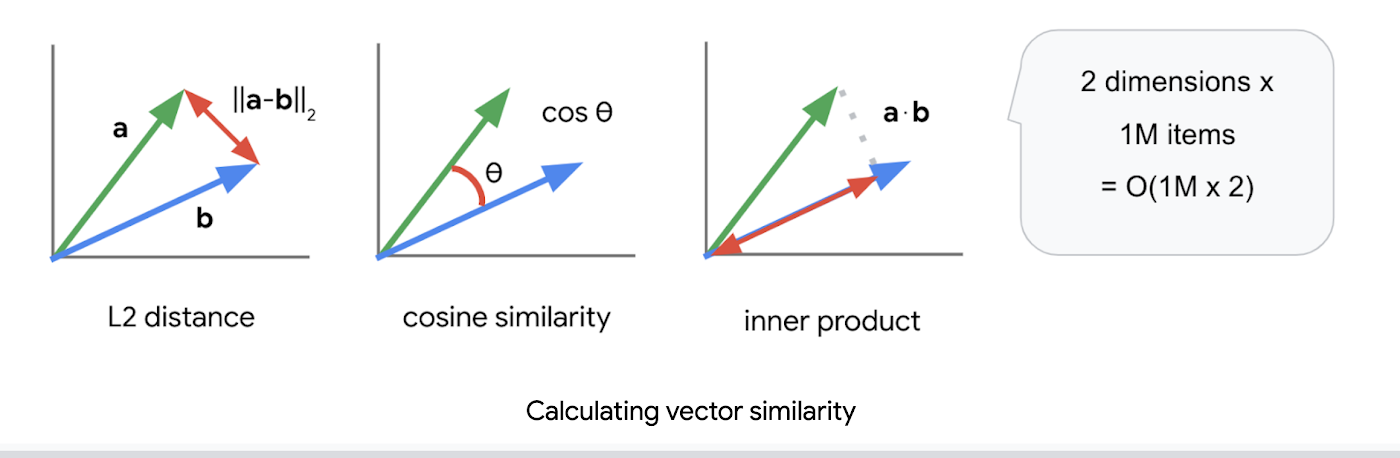

In [ ]:
def nodes_distance(node_a, node_b):
    n = len(node_a)
    anode = np.array(node_a)
    bnode = np.array(node_b)
    min_dist = np.zeros(n)
    for i in range(n):
        idist = cdist(anode[i].reshape(1, -1), bnode)
        min_dist[i] = idist.min()
        bnode = bnode[bnode[:, 0] != bnode[idist.argmin(), 0]]
    return min_dist.mean()

In [ ]:
case_similarity = np.zeros(len(case_base))
for i in range(len(case_base)):
    case_similarity[i] = nodes_distance(case_base[i]["nodes"], user_model["nodes"])
idx = case_similarity.argmin()
print(f"Best Case Index Similarity: {idx} - {round(case_similarity.min(), 4)}")
visualize_user_model(user_model, case_base[idx])

### Recommendation Algorithm

In [ ]:
n2recomend = 5
tmdb_api_key = "5ab2383865ec68e340e05452655559e7"

def show_recomendations(recomendations):
    fig = make_subplots(rows=1, cols=5)
    for i, reco in enumerate(recomendations):
        movie_id = movies_data.loc[movies_data.original_title == reco, "id"].values[0]
        url = "https://api.themoviedb.org/3/movie/{}?api_key=5ab2383865ec68e340e05452655559e7&language=en-US".format(movie_id)
        response = requests.get(url, headers={"accept": "application/json"})
        data = response.json()
        try:
            img = io.imread(f"https://image.tmdb.org/t/p/w500{data['poster_path']}")
        except Exception:
            img = np.zeros((278, 185, 3))
        fig.add_trace(
            go.Image(z=img),
            row=1,
            col=i+1,
        )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.show()

In [ ]:
recomended_titles = []
for idx in case_similarity.argsort()[:100]:
    icase = case_base[idx]
    ititles = sorted(set(icase["titles"]) - set(user_model["titles"]).union(set(recomended_titles)))
    if ititles:
        imovies = movies_data.loc[movies_data.original_title.isin(ititles)].sort_values(
            by="vote_average", ascending=False, ignore_index=True
        ).iloc[0].to_dict()
        recomended_titles.append(imovies["original_title"])
        if len(recomended_titles) <= n2recomend:
            print(f"""{len(recomended_titles)}. {imovies["original_title"]}""")
            irecomended = recomended_titles[:n2recomend]
            idr = 5
show_recomendations(irecomended)

# 3. Revise: Having mapped the previous solution to the target situation, test the new solution in the real world (or a simulation) and, if necessary, revise.

In [ ]:
likes = [True, True, False, False, True]

In [ ]:
# Iterate until all likes
if sum(likes) < n2recomend:
    irecomended = [x for i, x in enumerate(irecomended) if likes[i]]
    next_idr = idr + (n2recomend - sum(likes))
    irecomended.extend(recomended_titles[idr:next_idr])
    idr = next_idr
for i, x in enumerate(irecomended):
    print(f"{i+1}. {x}")

In [ ]:
show_recomendations(irecomended)

In [ ]:
recomendation_model = get_user_model(irecomended)
visualize_user_model(user_model, recomendation_model)

# 4. Retain: After the solution has been successfully adapted to the target problem, store the resulting experience as a new case in memory.

### Update or Add user model

In [ ]:
user_model = get_user_model(user_model["titles"] + irecomended)

In [ ]:
if case_similarity.min() == 0:
    # update user
    idx = case_similarity.argmin()
    case_base[idx] = user_model.copy()
    print(f"Case Id {idx} updated")
else:
    # add new user
    case_base.append(user_model.copy())
    print(f"New Case Id {len(case_base) - 1} added")

In [ ]:
visualize_user_model(user_model)

In [ ]:
# Back to Base Cases
case_base = case_base[:1000]

### Presentación:
- 5: Problem Definition (MLOps) + Use Cases: 
    - Price Prediction
    - Movies Recomendation
- 5: Architecture for Model Inference
- 5: Input Processing
- 5: Model Predictor
- 5: Model Deployment